# Darwin: optimization vs understanding

In [1]:
import os.path
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def genSample(mu, sigma, size, sparse = 1.0 ):
  mu = mu * (1.0 / sparse)
  pad = int(size - (size * sparse))
  size = size - pad
  rpad = np.full(pad,0, dtype=float)
  rval = np.random.normal(loc=mu, scale=sigma, size=size)
  if pad > 0:
    rval = list(rval) + list(rpad)
  return ( pd.Series(rval) )

In [3]:
def Bootstrap(data, R = 1000):
    rval = list()
    r = 0
    sampleSize = len(data)
    while r < R:
            tsample = data.sample(n=sampleSize, replace=True)
            avg = tsample.mean()
            rval.append(avg)
            r += 1
    return (pd.Series(rval))

In [8]:
sample1 = genSample(1,0.25,100000)
sample2 = genSample(1.1,0.25,100000)
sample3 = genSample(1.1,0.25,100000, 0.25)
sample4 = genSample(1.0,0.25,100000, 0.25)

In [9]:
v1 = Bootstrap(sample1, 2500)
v2 = Bootstrap(sample2, 2500)
v3 = Bootstrap(sample3, 2500)
v4 = Bootstrap(sample4, 2500)

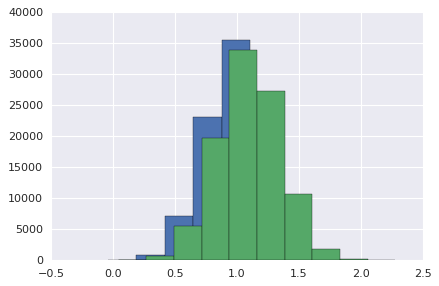

In [10]:
sample1.hist()
sample2.hist()

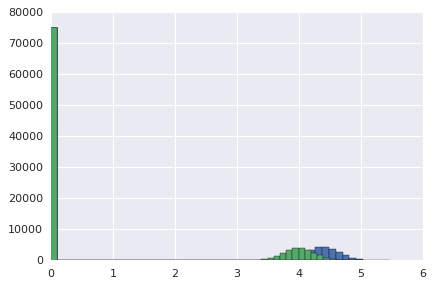

In [11]:
sample3.hist(bins=50)
sample4.hist(bins=50)

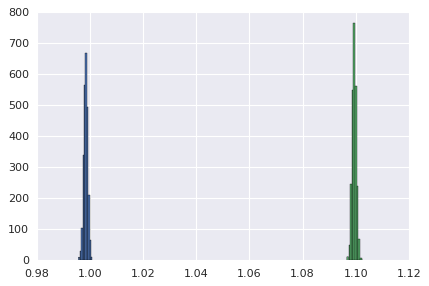

In [12]:
v1.hist()
v2.hist()

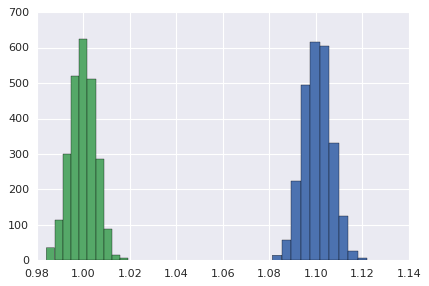

In [13]:
v3.hist()
v4.hist()

In [22]:
print stats.norm.fit(v1.tolist())
print stats.norm.fit(v2.tolist())

(0.99890429717956863, 0.00078227330525242153)
(1.1017442589506594, 0.00079230803544574446)


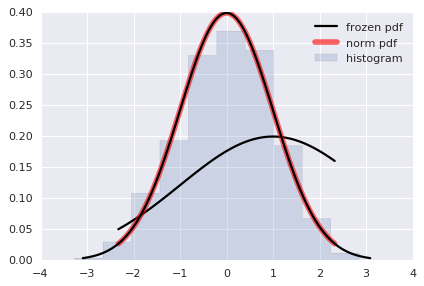

In [73]:
from scipy.stats import norm
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
x = np.linspace(norm.ppf(0.01), norm.ppf(0.99), 100)
rv = norm(1,2)
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')

x = np.linspace(norm.ppf(0.01), norm.ppf(0.99), 100)
ax.plot(x, norm.pdf(x), 'r-', lw=5, alpha=0.6, label='norm pdf')

r = norm.rvs(size=1000)
ax.hist(r, normed=True, histtype='stepfilled', alpha=0.2, label = 'histogram')
ax.legend(loc='best', frameon=False)


x = np.linspace(norm.ppf(0.001), norm.ppf(0.999), 100)
rv = norm()
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')


plt.show()

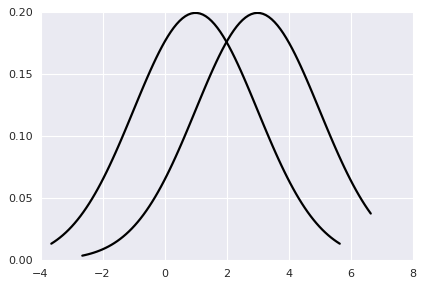

In [74]:
fi, ay = plt.subplots(1, 1)
rv1 = norm(1,2)
rv2 = norm(2,2)
x1 = np.linspace(rv1.ppf(0.01), rv1.ppf(0.99), 100)
x2 = np.linspace(rv2.ppf(0.01), rv2.ppf(0.99), 100)
ay.plot(x1, rv1.pdf(x1), 'k-', lw=2, label='rv1')
ay.plot(x2, rv2.pdf(x1), 'k-', lw=2, label='rv1')